# Import libraries
- numpy - for fast computations
- scipy - for loading matlab files (.mat extension)
- matplotlib - for plotting images

In [1]:
import numpy as np
from numpy.linalg import svd
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Define Main Functions

- featureNormalize - which normalizes matrix values to be normally distributed (Mean=0, STD=1)
- pca - does Singular Value Decomposition and calculates pca for given matrix
- projectData - projects data on basis which consists of top K meaningful Eigenvectors
- recoverData - recovers data after projection and generates image approximations

In [2]:
def featureNormalize(X):
    """
    Returns a normalized version of X where the mean value of each feature is 0 and the standard deviation is 1.
    """
    # calculates mean and standard deviation
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)

    # normalized each matrix element to have them normally distributed N(0,1) (mean=0, std=1)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [3]:
def covariance(X):
    m, n = X.shape[0], X.shape[1]

    X_cov = 1 / (m - 1) * X.T @ X

    return X_cov

In [4]:
def pca(X):
    """
    Computes eigenvectors of the covariance matrix of X
    """
    sigma = covariance(X)

    U, S, V = svd(sigma)

    return U, S, V

In [5]:
def projectData(X, U, K):
    """
    Computes the reduced data representation when projecting only on to the top k eigenvectors
    """
    m = X.shape[0]
    U_reduced = U[:, :K]
    Z = np.zeros((m, K))

    for i in range(m):
        for j in range(K):
            Z[i, j] = X[i, :] @ U_reduced[:, j]

    return Z  # Project the data onto K=1 dimension

In [6]:
def recoverData(Z, U, K):
    """
    Recovers an approximation of the original data when using the projected data
    """
    m, n = Z.shape[0], U.shape[0]
    X_rec = np.zeros((m, n))
    U_reduced = U[:, :K]

    for i in range(m):
        X_rec[i, :] = Z[i, :] @ U_reduced.T

    return X_rec

In [7]:
def show_flattened_vectors(matrix, k: int, title: str):
    """Shows first K vectors as an reshaped 32x32 dimensional images from X matrix"""

    # calculate dimension of plot matrix which fits all K feature representations (as images) which will look like as eigenfaces
    PLOT_MATRIX_DIM = 2 if k == 1 else int(np.ceil(np.sqrt(k)))

    # take matrix of only that first K features
    reduced_matrix = matrix[:, :k].T

    # plotting compressed images
    fig2, ax2 = plt.subplots(PLOT_MATRIX_DIM, PLOT_MATRIX_DIM, figsize=(18, 18))

    for i in range(0, PLOT_MATRIX_DIM ** 2, PLOT_MATRIX_DIM):
        for j in range(PLOT_MATRIX_DIM):
            if i + j < k:
                reshaped_image = reduced_matrix[i + j, :].reshape(32, 32, order="F")
                ax2[int(i / PLOT_MATRIX_DIM), j].imshow(reshaped_image, cmap="gray")
                ax2[int(i / PLOT_MATRIX_DIM), j].axis("off")
    _ = fig2.suptitle(title, fontsize=30)

# Load and visualize the Face image dataset

In [8]:
from pathlib import Path

resources = Path.cwd() / "resources"

In [9]:
mat = loadmat(resources / "principal-component-analysis" / "ex7faces.mat")
X = mat["X"]

Each image size is 32x32 and they are flattened in 1024 size vector. We have 5K images in total.

In [10]:
X.shape

(5000, 1024)

## create subplots to show multiple images
1. unflatten image vectors
2. plot images
3. turn off axis to have less noise on plots

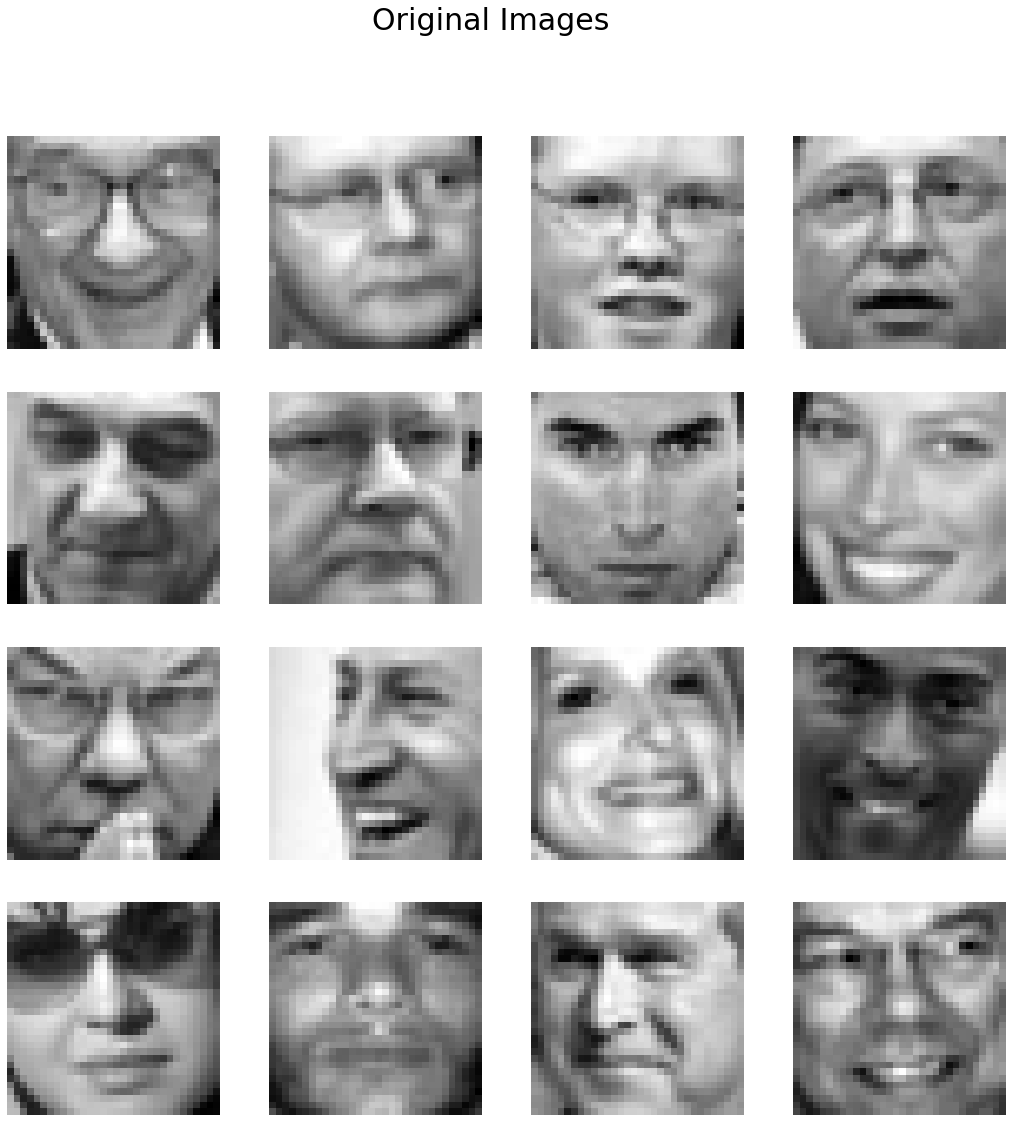

In [11]:
show_flattened_vectors(X.T, k=16, title="Original Images")

# Normalize matrix of flattened images

In [12]:
X_norm, _, _ = featureNormalize(X)

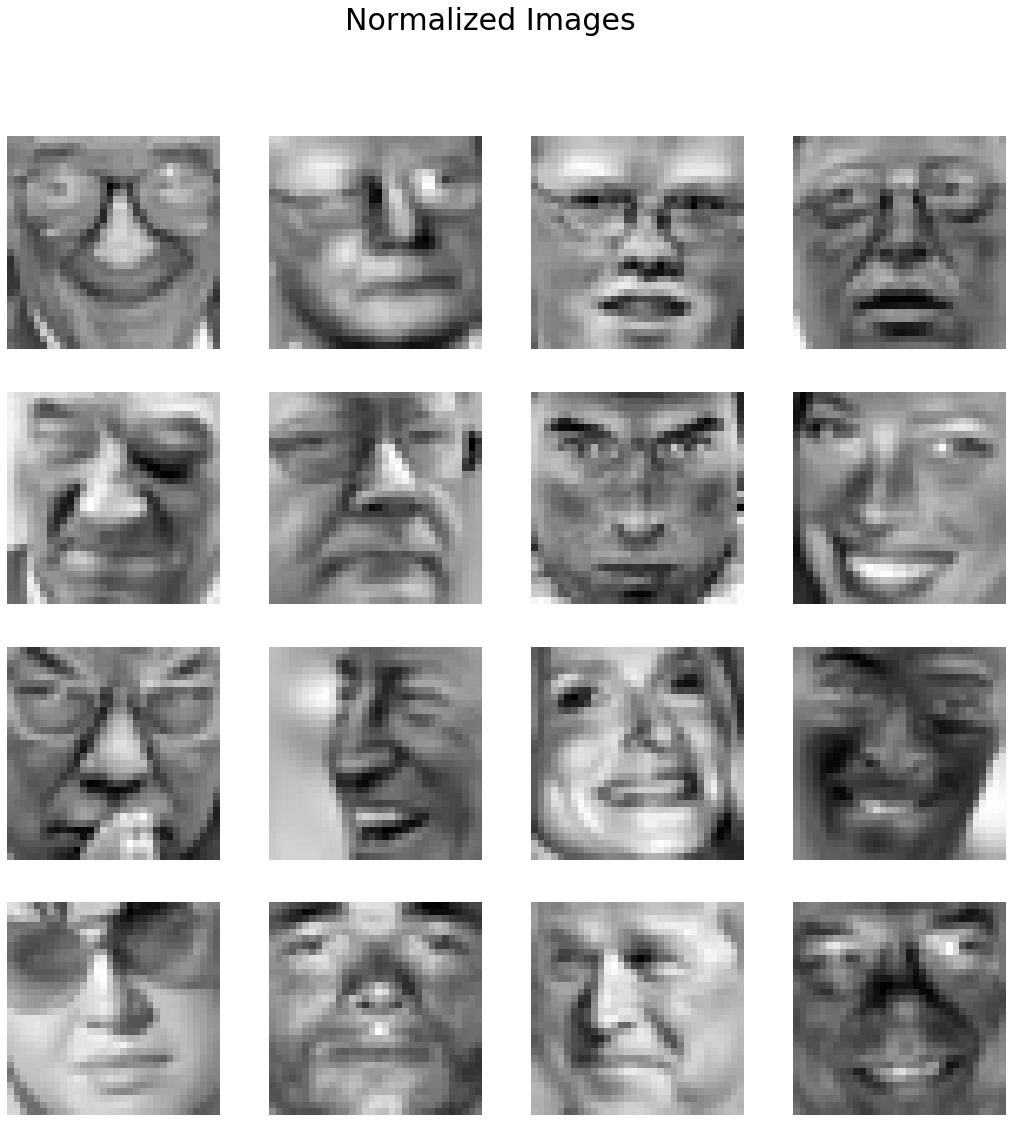

In [13]:
show_flattened_vectors(X_norm.T, k=16, title="Normalized Images")

### Run PCA

**U** and **V** are **left singular** and **right singular** vectors of covariance matrix of **X normalized** matrix

**S** is known as singular values vector which in fact is a representation of diagonal matrix

In [14]:
U, S, V = pca(X_norm)

# Understanding U, S, V matrices

In [15]:
X_norm.shape

(5000, 1024)

In [16]:
U.shape, S.shape, V.shape

((1024, 1024), (1024,), (1024, 1024))

## $U$ and $V^T$ are equal (Almost) because they are containing left and right singular vectors of covariance matrix which is symmetric

In [17]:
U[1, :]

array([-0.01474233, -0.03809858, -0.04756249, ..., -0.01142763,
       -0.00228691, -0.00434598])

In [18]:
V[:, 1]

array([-0.01474233, -0.03809858, -0.04756249, ..., -0.01142763,
       -0.00228691, -0.00434598])

In [19]:
np.linalg.norm(U - V.T)

4.479180832541671e-11

# Show Singular Values

## All singular values

<BarContainer object of 1024 artists>

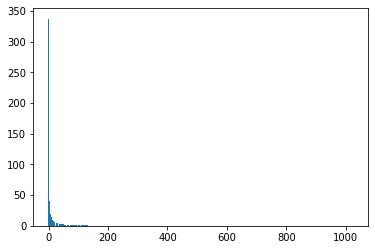

In [20]:
plt.bar(range(S.shape[0]), S)

In [21]:
U.shape

(1024, 1024)

In [22]:
V.shape

(1024, 1024)

## Top 50 singular values

<BarContainer object of 50 artists>

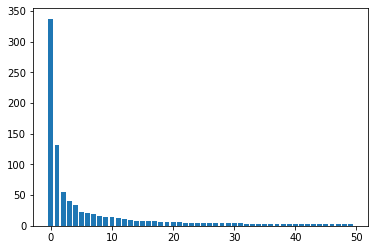

In [23]:
plt.bar(range(50), S[:50])

# Below is the visualization of 36 principal components or eigenvectors or eigenfaces that describe the largest variations in the dataset

These vectors are looking as if they were reduces form of original images but they are eigenfaces. If we want to map our n=1024 dimensional images into lower K dimensional (K<<n) space, we are saving coefficients for first K eigenvectors/eigenfaces and then we can get reconstruction (approximate) of original images with linear combination of these first K important eigenfaces with saved coefficients. 

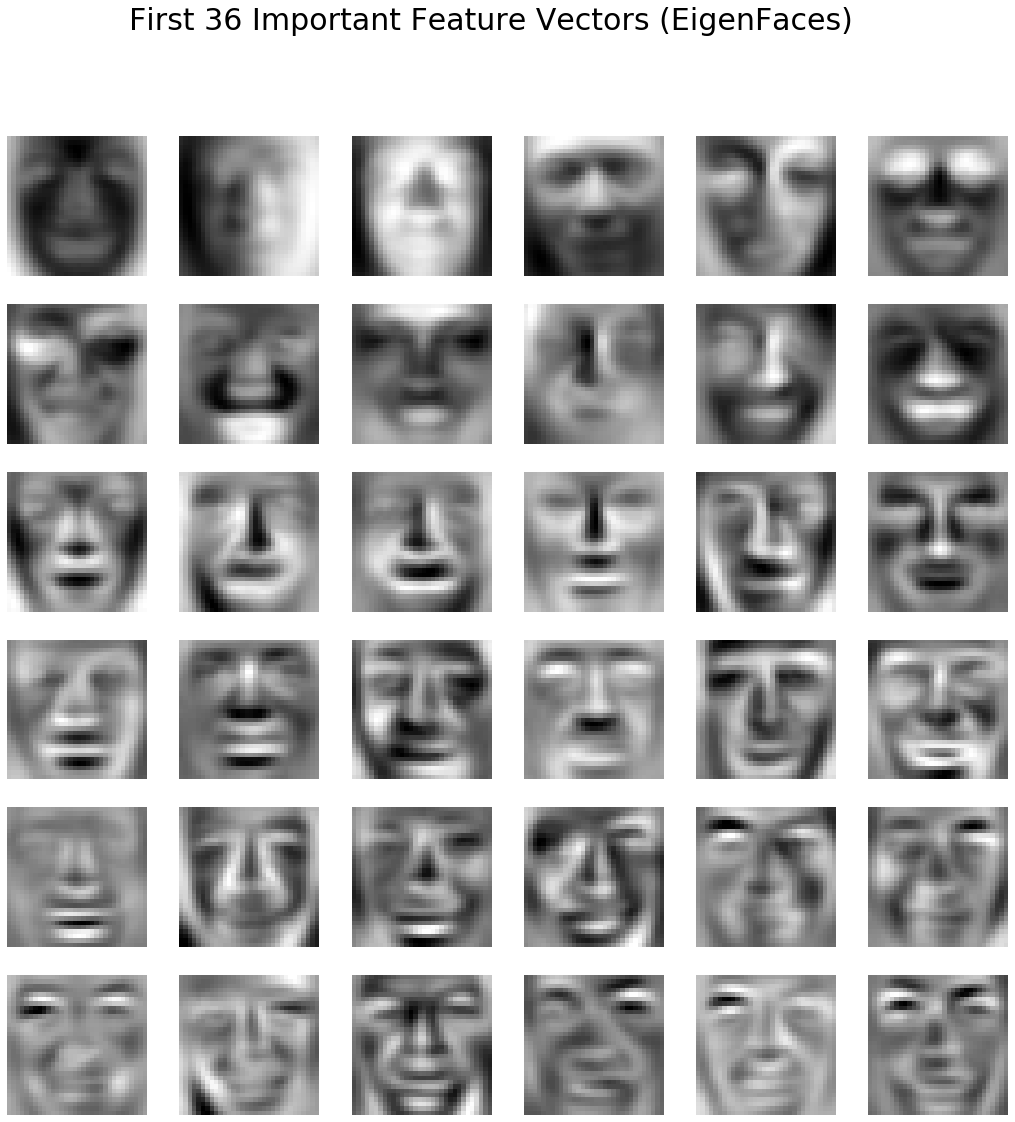

In [24]:
show_flattened_vectors(U, k=36, title="First 36 Important Feature Vectors (EigenFaces)")

# Let's try to take 36 last principal components instead of first. We will see that these last eigenfaces aren't impressive since they contain almost random noise.

I am just passing matrix of last 36 feature vectors as a parameter to avoid problems with indices since it takes first K element and it's impossible to access slice of [:, -k:] 

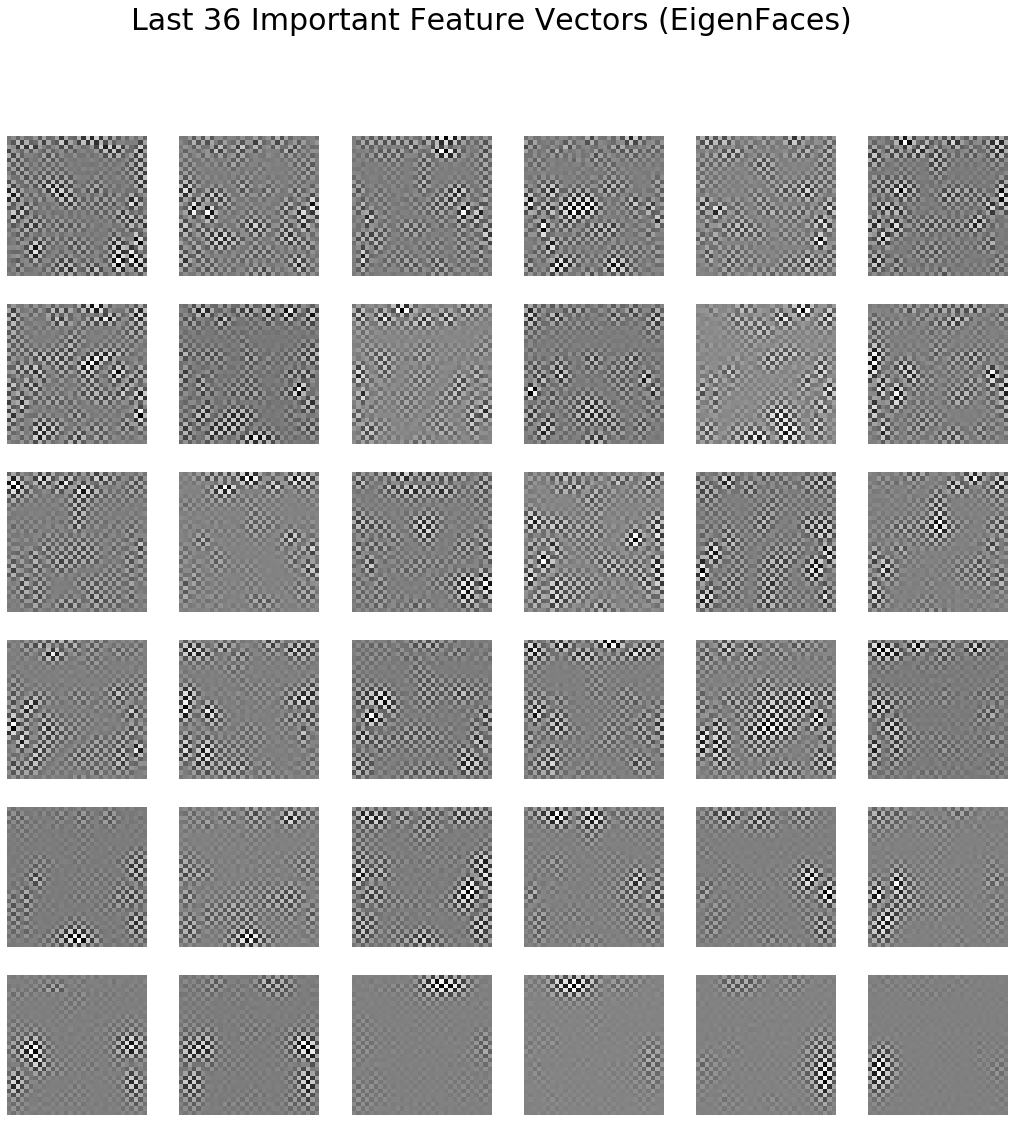

In [25]:
show_flattened_vectors(
    U[:, -36:], k=36, title="Last 36 Important Feature Vectors (EigenFaces)"
)

# Let's project the data onto the first K=100 principal components and recover back. Try to understand what is lost in the dimensionality reduction process.

In [26]:
K = 100
Z = projectData(X_norm, U, K)
print("The projected data Z has a size of:", Z.shape)

### Data reconstruction
X_rec = recoverData(Z, U, K)

The projected data Z has a size of: (5000, 100)


### Visualize the reconstructed data

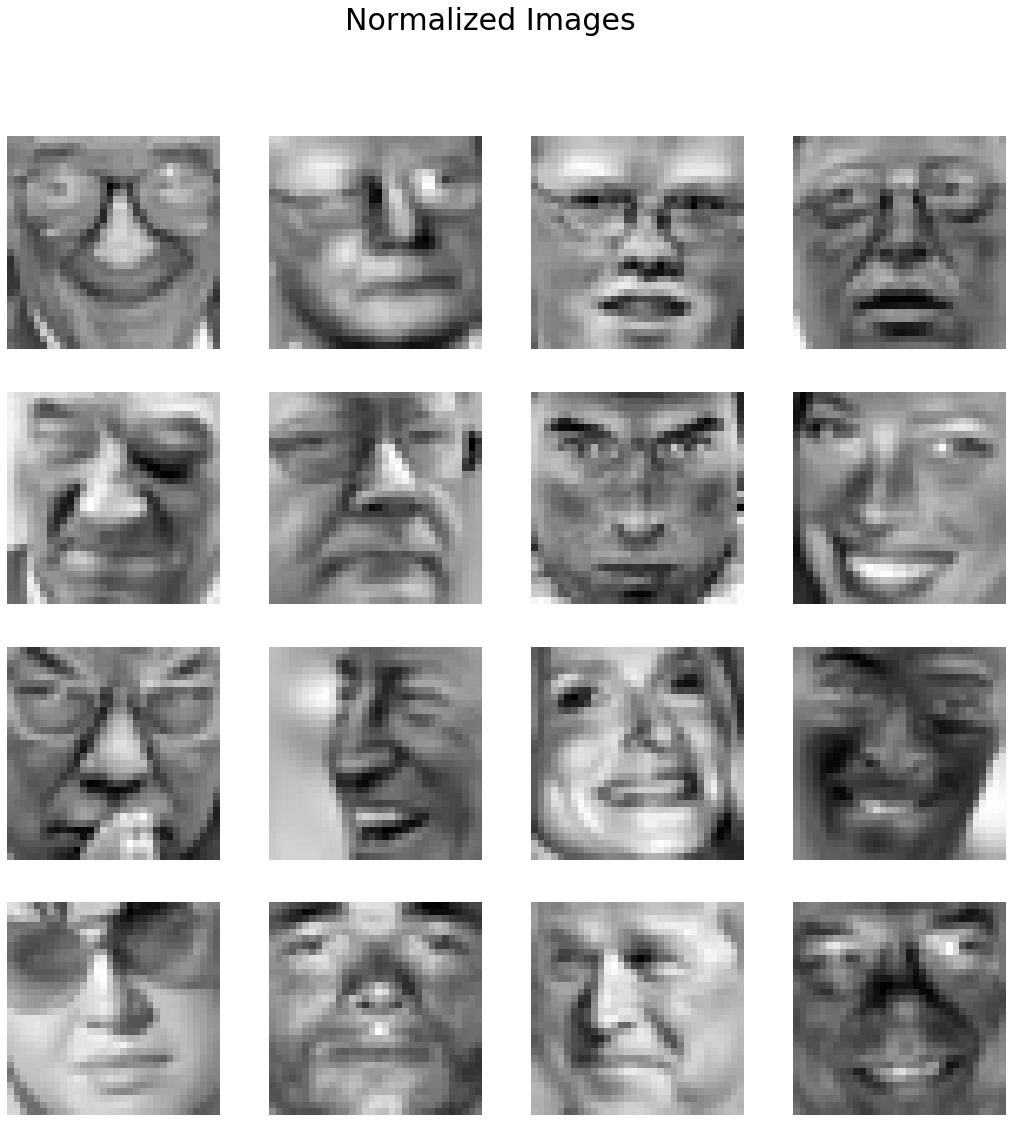

In [27]:
show_flattened_vectors(X_norm.T, k=16, title="Normalized Images")

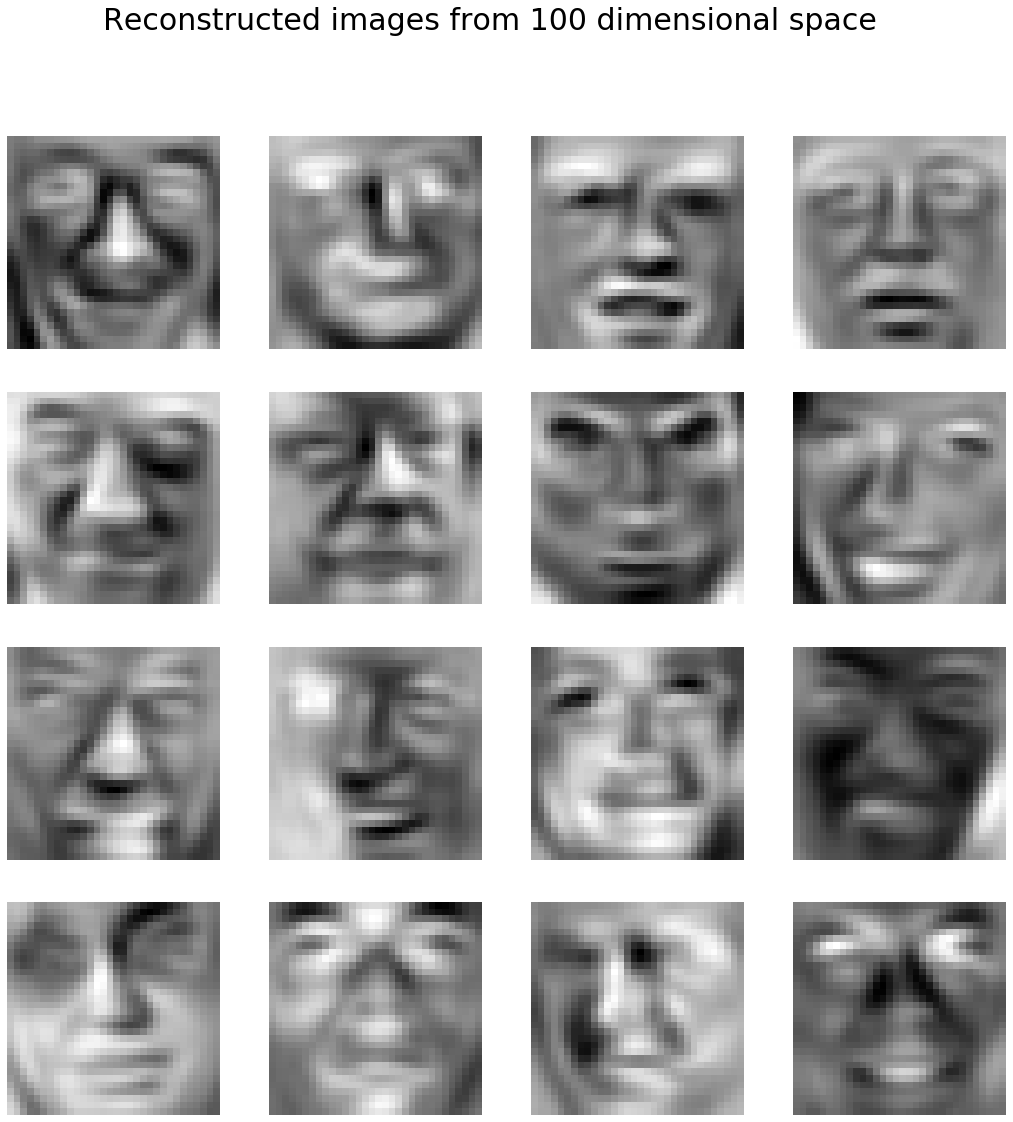

In [28]:
show_flattened_vectors(
    X_rec.T, k=16, title=f"Reconstructed images from {K} dimensional space"
)

# Let's project the data onto the first K=1 principal components and recover back. Try to understand what is lost in the dimensionality reduction process.

In [29]:
K = 1
Z = projectData(X_norm, U, K)
print("The projected data Z has a size of:", Z.shape)

### Data reconstruction
X_rec = recoverData(Z, U, K)

The projected data Z has a size of: (5000, 1)


### Visualize the reconstructed data

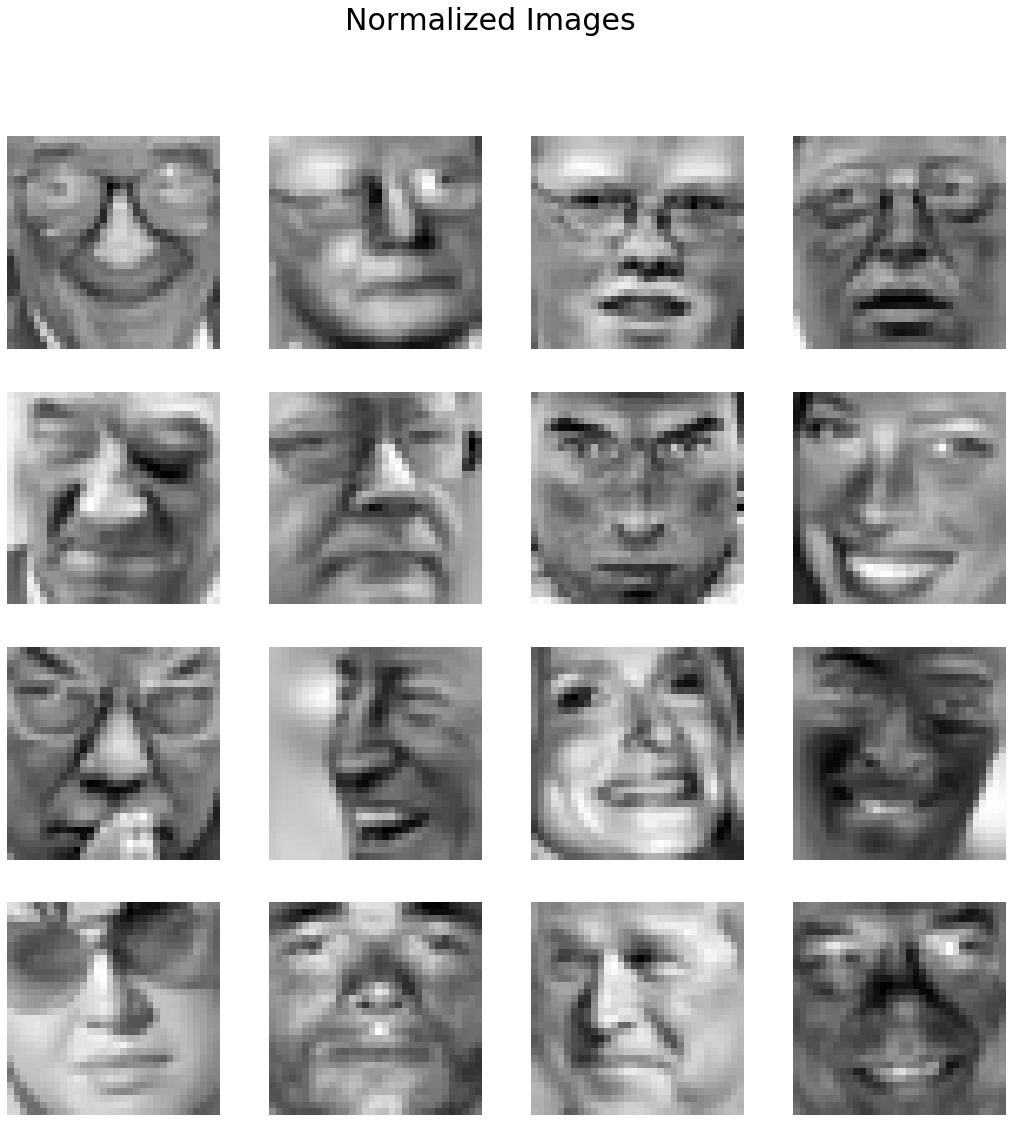

In [30]:
show_flattened_vectors(X_norm.T, k=16, title="Normalized Images")

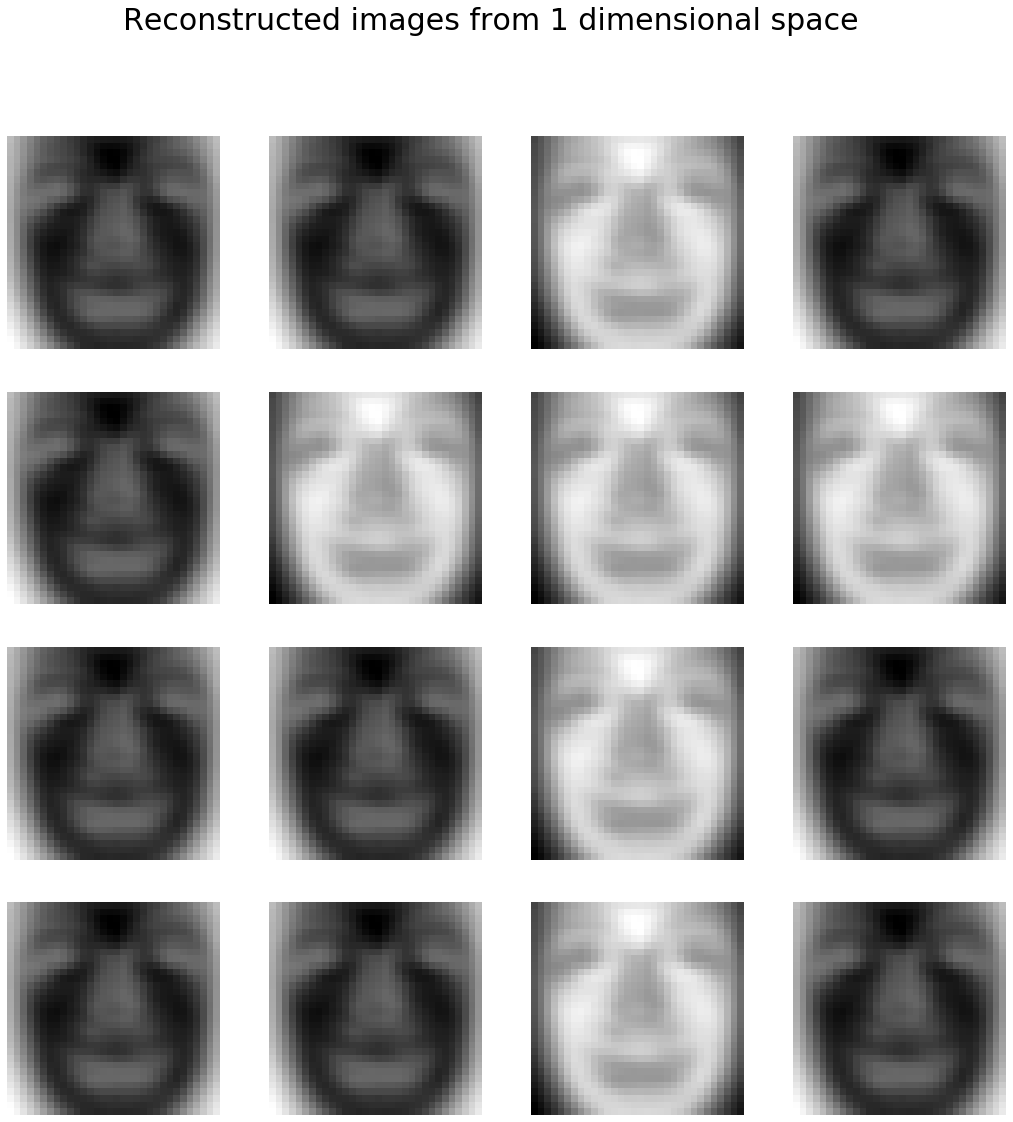

In [31]:
show_flattened_vectors(
    X_rec.T, k=16, title=f"Reconstructed images from {K} dimensional space"
)

If we check first feature with highest singular value in V matrix we will see that all of these representations of images come from that feature with little scaling. They are multiplied with the coefficient to have their reconstruction as close as possible with original images

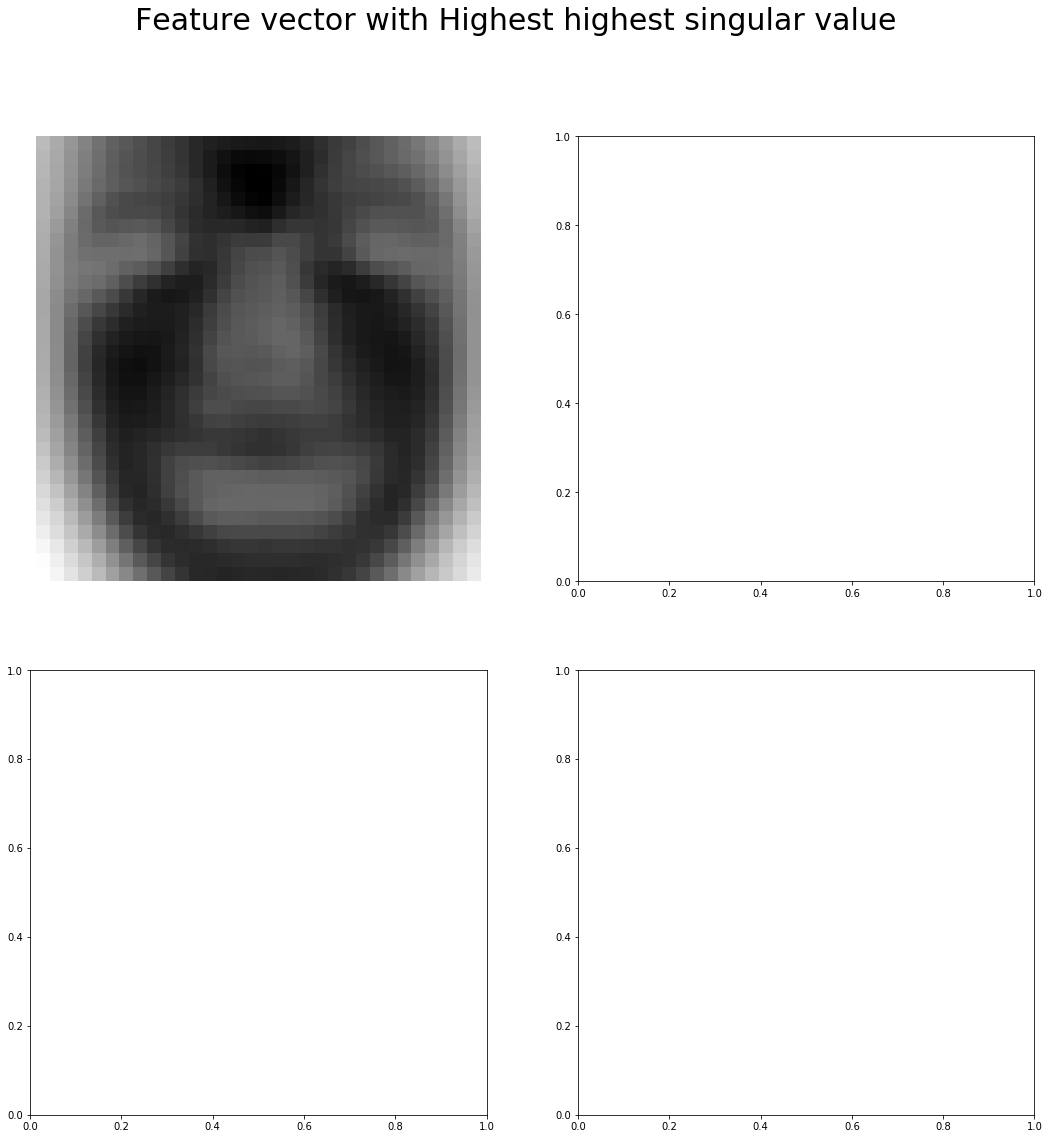

In [32]:
show_flattened_vectors(
    U, k=1, title="Feature vector with Highest highest singular value"
)